In [1]:
import numpy as np
import torch
import random
import pickle
import pandas as pd

import torch.nn as nn
import torch.optim as optim

from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

from datasets import load_dataset


### https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
if torch.cuda.is_available():
    dev = torch.cuda.current_device()
    torch.cuda.device(dev)
    print("Using", torch.cuda.get_device_name(0))
else:
    torch.device("cpu")

Using GeForce GTX 1060


### Processing the data [DailyDialog] to make it task specific

In [4]:
dataset = load_dataset('daily_dialog')
print(dataset)

Using custom data configuration default


Dataset daily_dialog downloaded and prepared to /home/sambit/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1781b6e74e1ba5c8b5bcbf7c210656d54474ec1a9b3feadc88a4fc229be2145c. Subsequent calls will reuse this data.
DatasetDict({
    train: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 11118
    })
    test: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
    validation: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
})


In [5]:
dataset['train'][:2]

OrderedDict([('act', [[3, 4, 2, 2, 2, 3, 4, 1, 3, 4], [2, 1, 2, 2, 1, 1]]),
             ('dialog',
              [['Say , Jim , how about going for a few beers after dinner ? ',
                ' You know that is tempting but is really not good for our fitness . ',
                ' What do you mean ? It will help us to relax . ',
                " Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? ",
                " I guess you are right.But what shall we do ? I don't feel like sitting at home . ",
                ' I suggest a walk over to the gym where we can play singsong and meet some of our friends . ',
                " That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . ",
                ' Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . ',
                " Good.Let ' s go now . ",
     

In [29]:
def split_data_into_lists(mode):
    global dataset
    temp_data = dataset[mode]
    rows = []
    
    for i, d in enumerate(temp_data):
        acts = d["act"]
        dialogs = d["dialog"]
        emotions = d["emotion"]
        
        for idx in range(0, len(acts)):
            if emotions[idx] == 0:
                continue
            rows.append([dialogs[idx], acts[idx], emotions[idx]])
            
    df = pd.DataFrame(data=rows, columns=['current_dialog', 'act', 'emotion'])
    df.to_csv("data/daily_dialog_single/csv/"+mode+".csv", index=False)

In [30]:
### UNCOMMENT IF THE DATA SPLITTING PROCESS IS CHANGED
split_data_into_lists("test")
split_data_into_lists("validation")
split_data_into_lists("train")

### Pre-processing for BERT

In [31]:
ohe_act = OneHotEncoder(handle_unknown='ignore')
X = [[1], [2], [3], [4]]
ohe_act.fit(X)

# { 1: inform，2: question, 3: directive, 4: commissive }

ohe_emo = OneHotEncoder(handle_unknown='ignore')
X = [[0], [1], [2], [3], [4], [5], [6]]
ohe_emo.fit(X)

# { 0: no emotion, 1: anger, 2: disgust, 3: fear, 4: happiness, 5: sadness, 6: surprise}

print(ohe_act.transform([[1]]).toarray())
print(ohe_emo.transform([[4]]).toarray())

[[1. 0. 0. 0.]]
[[0. 0. 0. 0. 1. 0. 0.]]


In [32]:
def load_csv(mode):
    df = pd.read_csv("data/daily_dialog_single/csv/"+mode+".csv")
    return df

# Get the dialog from the generated dataframe
def get_cell(df, row, column_name):
    return df.loc[df.index[row], column_name]

### Loading and tokenizing the data

In [33]:
train = load_csv("train")
val = load_csv("validation")
test = load_csv("test")

In [34]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
sentence = get_cell(train, 0, "current_dialog")
print("Original:", sentence)
tokenized = tokenizer.tokenize(sentence)
print("Tokenised:", tokenized)
tokenided = tokenizer.convert_tokens_to_ids(tokenized)
print("Token ID:", tokenided)

Original:  That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . 
Tokenised: ['that', "'", 's', 'a', 'good', 'idea', '.', 'i', 'hear', 'mary', 'and', 'sally', 'often', 'go', 'there', 'to', 'play', 'ping', '##pon', '##g', '.', 'perhaps', 'we', 'can', 'make', 'a', 'fours', '##ome', 'with', 'them', '.']
Token ID: [2008, 1005, 1055, 1037, 2204, 2801, 1012, 1045, 2963, 2984, 1998, 8836, 2411, 2175, 2045, 2000, 2377, 17852, 26029, 2290, 1012, 3383, 2057, 2064, 2191, 1037, 23817, 8462, 2007, 2068, 1012]


In [35]:
# Tokenize the current and previous dialog for a specific row
# Can return emotion data or act data depending on "mode"

max_previous_length = 0
max_current_length = 0

def get_processed_row(df, row, mode="emo"):
    global  max_previous_length
    global max_current_length
    
    sentence = get_cell(df, row, "current_dialog")
    tokenized = tokenizer.tokenize(sentence)
    tokenided_c = tokenizer.convert_tokens_to_ids(tokenized)
    
    if len(tokenided_c) > max_current_length:
        max_current_length = len(tokenided_c)
    
    label = None
    
    if mode == "act":
        label = ohe_act.transform([[get_cell(df, row, "act")]]).toarray().flatten().tolist()
    else:
        label = ohe_emo.transform([[get_cell(df, row, "emotion")]]).toarray().flatten().tolist()
    
    return tokenided_c, label


# Save the sentence with one hot encoded labels (can be used with encode_plus)

def get_unprocessed_row(df, row, mode="emo"):
    global  max_previous_length
    global max_current_length
    
    sentence_c = get_cell(df, row, "current_dialog")
    
    label = None
    
    if mode == "act":
        label = get_cell(df, row, "act")
    else:
        label = get_cell(df, row, "emotion")
    
    return sentence_c, label

In [36]:
### Save tokenised data

def save_to_pkl(data, mode, dataset="emo"):
    with open("data/daily_dialog_single/pkl/"+mode+"_"+dataset+".pkl", "wb") as f:
        pickle.dump(data, f)

def save_to_sent(data, mode, dataset="emo"):
    with open("data/daily_dialog_single/sent/"+mode+"_"+dataset+".pkl", "wb") as f:
        pickle.dump(data, f)

### Generating PKLs for Emotion Data & Act Data (Sentences are tokenised)

In [37]:
import matplotlib.pyplot as plt

def plot_label_dist(label_dict):
    cols = label_dict.keys()
    vals = label_dict.values()
    
    print(label_dict)
    
    plt.bar(cols, vals)
    plt.show()

def get_label_counts(data):
    label_count = {}
    for d in data:
        if d[1] == 0:
            continue
        try:
            label_count[d[1]] += 1
        except KeyError:
            label_count[d[1]] = 1
    return label_count

In [38]:
train_data = []
for i in range(train.shape[0]):
    train_data.append(get_processed_row(train, i))
    
save_to_pkl(train_data, "train")

val_data = []
for i in range(val.shape[0]):
    val_data.append(get_processed_row(val, i))
save_to_pkl(val_data, "val")

test_data = []
for i in range(test.shape[0]):
    test_data.append(get_processed_row(test, i))
save_to_pkl(test_data, "test")


# train_data = []
# for i in range(train.shape[0]):
#     train_data.append(get_processed_row(train, i, "act"))
# save_to_pkl(train_data, "train", "act")

# val_data = []
# for i in range(val.shape[0]):
#     val_data.append(get_processed_row(val, i, "act"))
# save_to_pkl(val_data, "val", "act")

# test_data = []
# for i in range(test.shape[0]):
#     test_data.append(get_processed_row(test, i, "act"))
# save_to_pkl(test_data, "test", "act")

### Generating PKLs for Sentences

In [39]:
# Emo data

train_data = []
for i in range(train.shape[0]):
    train_data.append(get_unprocessed_row(train, i))
save_to_sent(train_data, "train")

val_data = []
for i in range(val.shape[0]):
    val_data.append(get_unprocessed_row(val, i))
save_to_sent(val_data, "val")

test_data = []
for i in range(test.shape[0]):
    test_data.append(get_unprocessed_row(test, i))
save_to_sent(test_data, "test")


# # Act data

# train_data = []
# for i in range(train.shape[0]):
#     train_data.append(get_unprocessed_row(train, i, "act"))
# save_to_sent(train_data, "train", "act")

# val_data = []
# for i in range(val.shape[0]):
#     val_data.append(get_unprocessed_row(val, i, "act"))
# save_to_sent(val_data, "val", "act")

# test_data = []
# for i in range(test.shape[0]):
#     test_data.append(get_unprocessed_row(test, i, "act"))
# save_to_sent(test_data, "test", "act")

{4: 11182, 6: 1600, 3: 146, 2: 303, 5: 969, 1: 827}


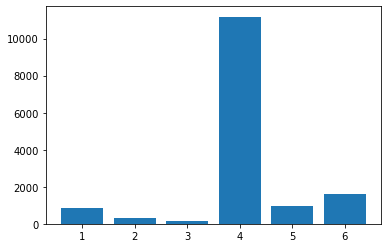

{4: 684, 1: 77, 5: 79, 6: 107, 3: 11, 2: 3}


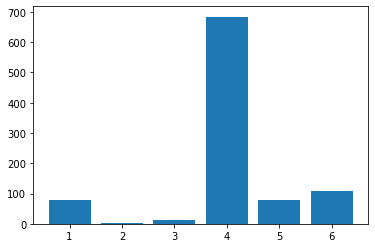

{6: 116, 3: 17, 4: 1019, 5: 102, 1: 118, 2: 47}


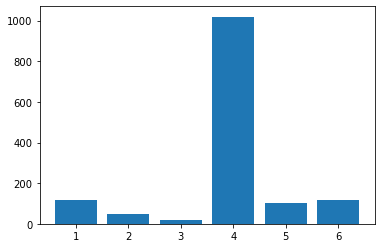

In [40]:
t1 = get_label_counts(train_data)
plot_label_dist(t1)

t2 = get_label_counts(val_data)
plot_label_dist(t2)

t3 = get_label_counts(test_data)
plot_label_dist(t3)